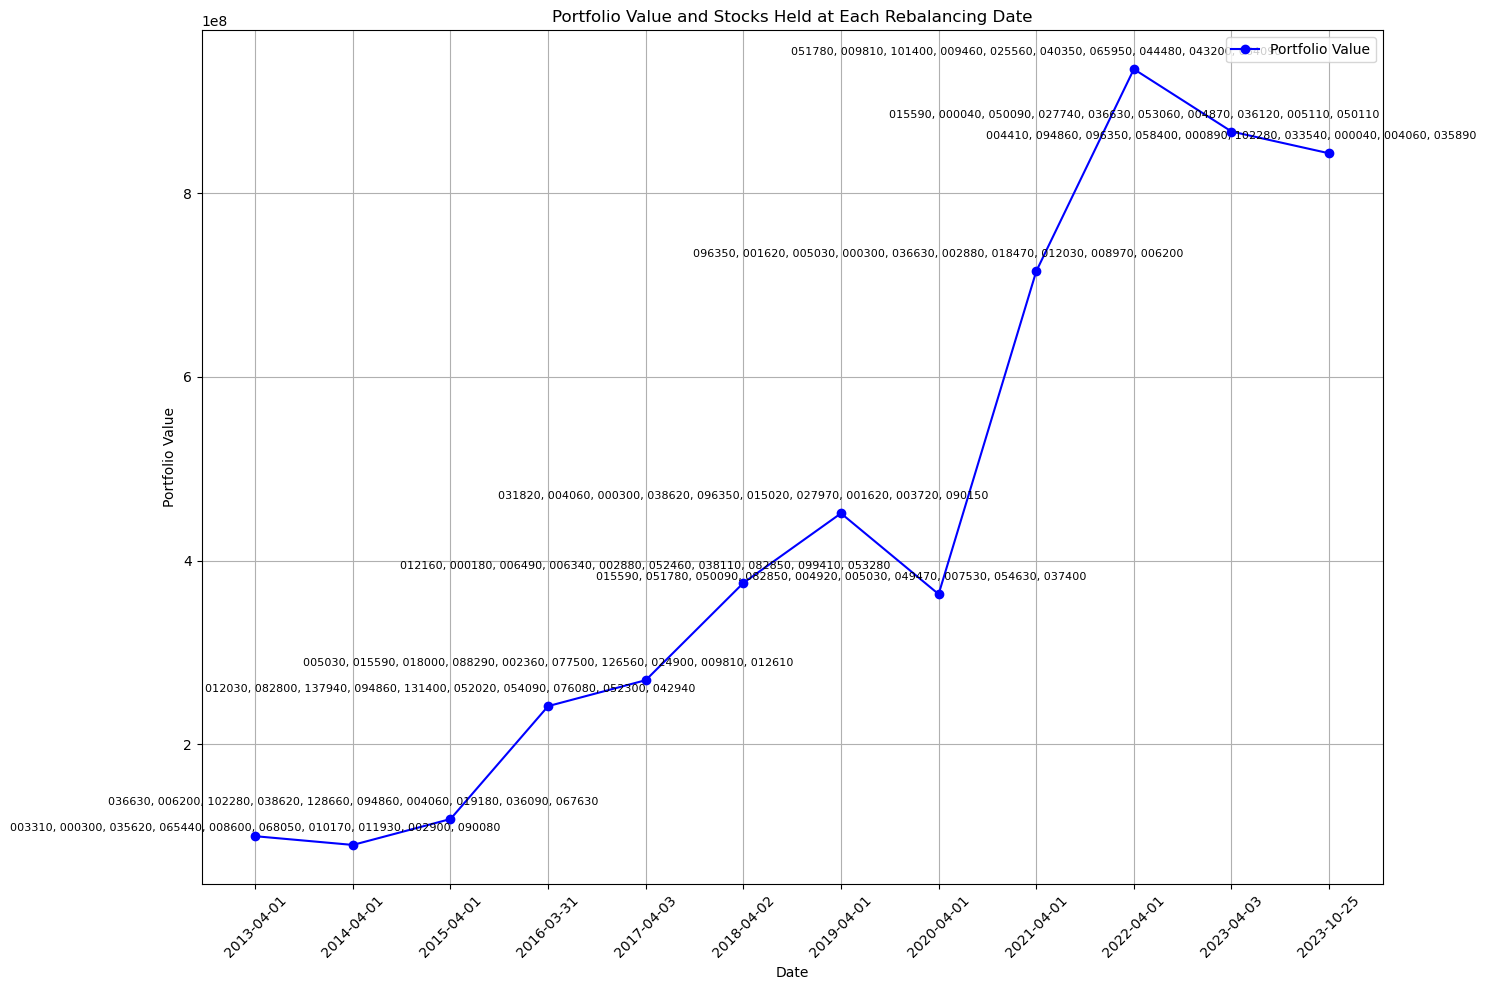

In [8]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드하기
close_df = pd.read_csv('close_df.csv')

# 데이터셋 내의 최신 날짜를 구하기
max_date = close_df['Date'].max()

# 리밸런싱일 정의하기
rebalancing_dates = ['2013-04-01', '2014-04-01', '2015-04-01', '2016-03-31', '2017-04-03', '2018-04-02', '2019-04-01', 
                     '2020-04-01', '2021-04-01', '2022-04-01', '2023-04-03']

# 초기 자본 및 거래 비용 설정
initial_capital = 100000000  # 1억 원
transaction_fee = 0.0015  # 0.15%

# 포트폴리오 값 변화를 저장할 리스트 초기화
portfolio_values = [initial_capital]
# 보유 종목을 저장할 리스트 초기화
held_stocks = []

# 각 리밸런싱일마다 반복
for idx, date in enumerate(rebalancing_dates):
    start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(date)
    
    period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
    
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    volatility = period_df[dropped_stocks].iloc[-60:].std()
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    # 보유 종목 저장
    held_stocks.append(selected_stocks)
    
    amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
    next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
    next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
    
    returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
    portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
    portfolio_values.append(portfolio_value)

# 결과 시각화하기
plt.figure(figsize=(15, 10))
plt.plot(rebalancing_dates + [max_date], portfolio_values, marker='o', linestyle='-', color='b', label='Portfolio Value')
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(held_stocks[i])
    plt.annotate(stocks_str, (date, portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
plt.title('Portfolio Value and Stocks Held at Each Rebalancing Date')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


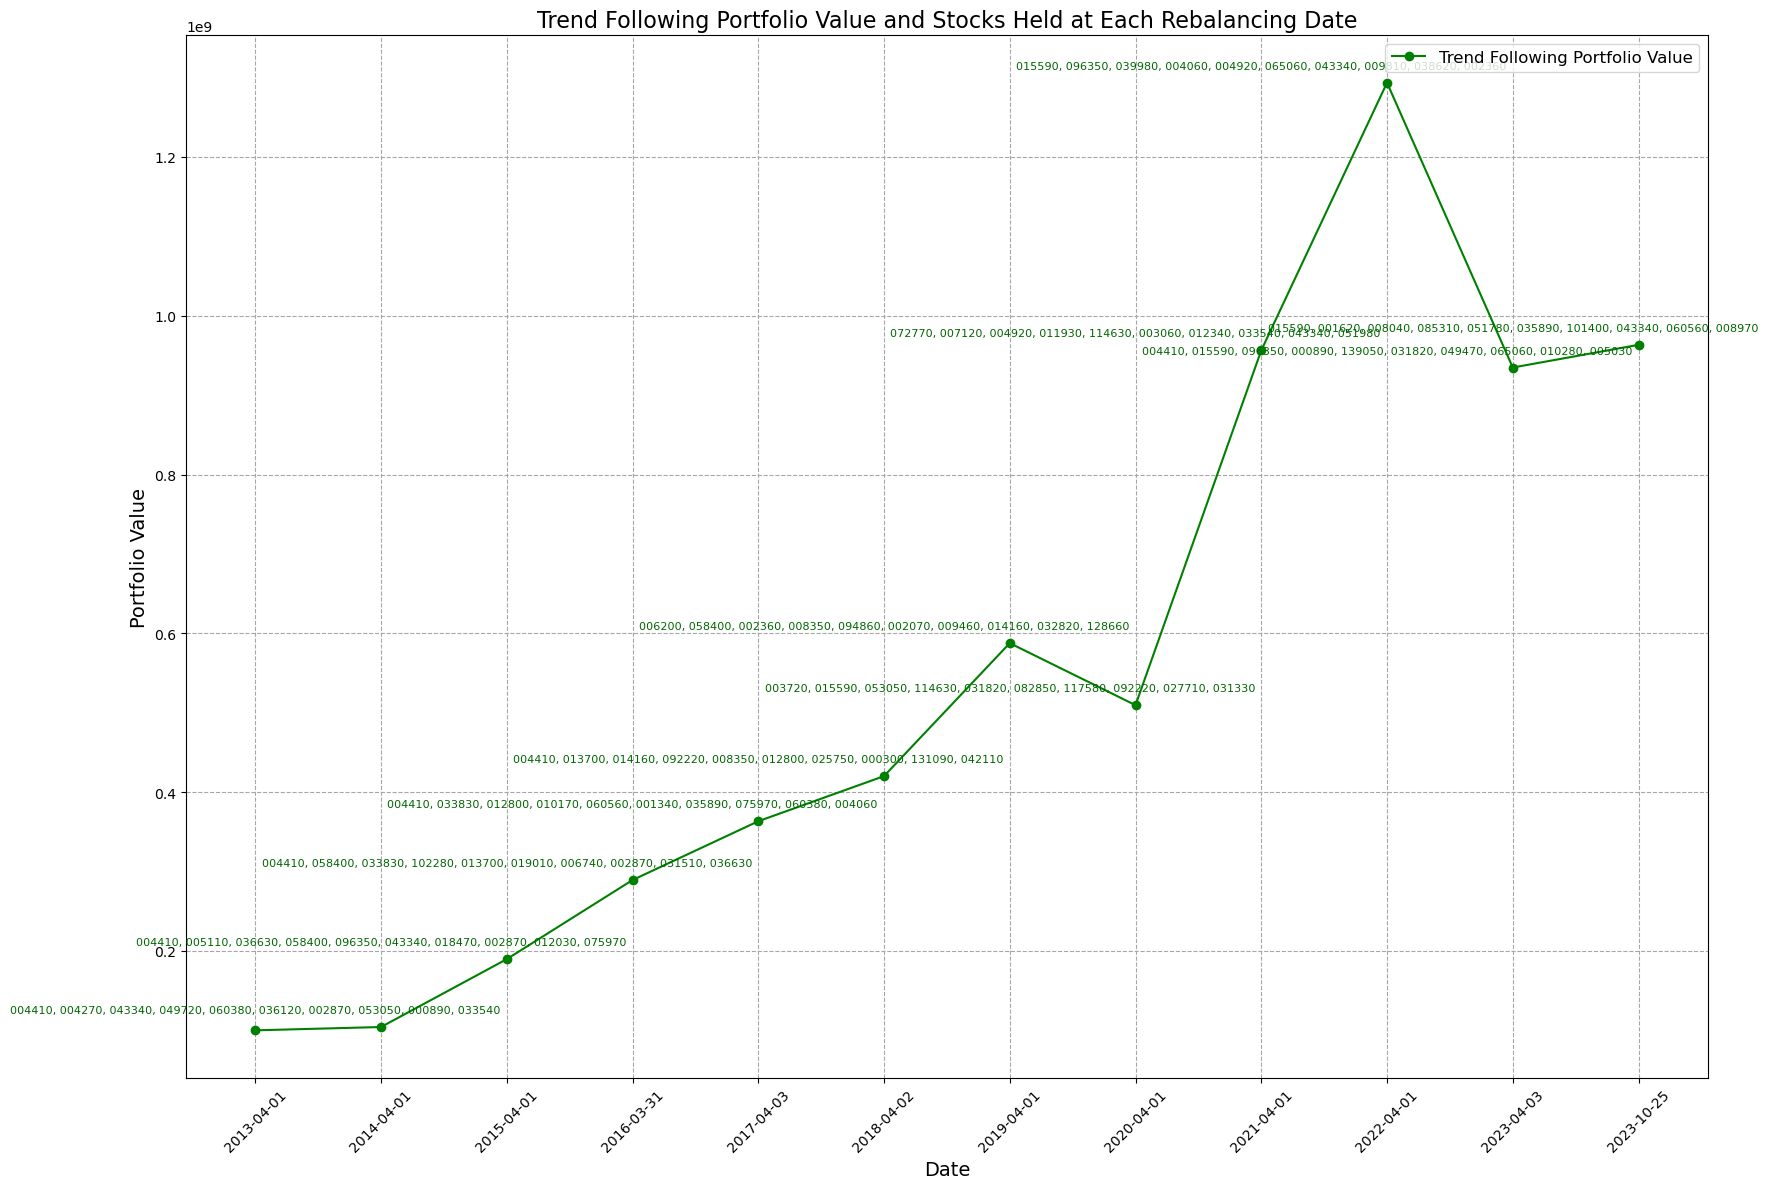

In [9]:
# 추세추종 전략 설정값
N = 50  # 이동평균 기간
M = 10  # 포트폴리오에 포함할 종목 수

# 포트폴리오 값 변화를 저장할 리스트 초기화
trend_portfolio_values = [initial_capital]
# 보유 종목을 저장할 리스트 초기화
trend_held_stocks = []

# 각 리밸런싱일마다 반복
for idx, date in enumerate(rebalancing_dates):
    start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(date)
    
    period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
    
    # 50일 이동평균 계산
    moving_average = period_df.rolling(window=N).mean().iloc[-1]
    current_price = period_df.iloc[-1]
    
    # 매수 시그널이 발생한 종목 선택
    buy_signals = current_price[current_price > moving_average].index.tolist()
    
    # 선택된 종목 중 변동성이 낮은 상위 10개의 종목 선택
    volatility = period_df[buy_signals].iloc[-60:].std()
    selected_stocks = volatility.nsmallest(M).index.tolist() if len(volatility) >= M else volatility.index.tolist()
    
    # 보유 종목 저장
    trend_held_stocks.append(selected_stocks)
    
    amount_per_stock = (trend_portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
    next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
    next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
    
    returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
    portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
    trend_portfolio_values.append(portfolio_value)

# 결과 시각화
plt.figure(figsize=(18, 12))
plt.plot(rebalancing_dates + [max_date], trend_portfolio_values, marker='o', linestyle='-', color='g', label='Trend Following Portfolio Value')
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(trend_held_stocks[i])
    plt.annotate(stocks_str, (date, trend_portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkgreen')
plt.title('Trend Following Portfolio Value and Stocks Held at Each Rebalancing Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", c='0.65')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
def mean_reversion_strategy(rebalancing_dates, close_df):
    portfolio_values = [initial_capital]
    held_stocks = []
    
    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)

        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')

        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()

        volatility = period_df[dropped_stocks].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()

        held_stocks.append(selected_stocks)

        amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
        next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')

        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
        portfolio_values.append(portfolio_value)
    
    return portfolio_values, held_stocks


def trend_following_strategy(rebalancing_dates, close_df):
    portfolio_values = [initial_capital]
    held_stocks = []

    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)

        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')

        moving_average = period_df.rolling(window=N).mean().iloc[-1]
        current_price = period_df.iloc[-1]

        buy_signals = current_price[current_price > moving_average].index.tolist()

        volatility = period_df[buy_signals].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(M).index.tolist() if len(volatility) >= M else volatility.index.tolist()

        held_stocks.append(selected_stocks)

        amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
        next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')

        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
        portfolio_values.append(portfolio_value)
    
    return portfolio_values, held_stocks


# 실행 및 시각화
mr_portfolio_values, mr_held_stocks = mean_reversion_strategy(rebalancing_dates, close_df)
tf_portfolio_values, tf_held_stocks = trend_following_strategy(rebalancing_dates, close_df)

# 성과 평가 지표 계산 함수
def performance_metrics(portfolio_values, rebalancing_dates):
    daily_returns = [0] + [(portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1] for i in range(1, len(portfolio_values))]
    cagr = ((portfolio_values[-1] / portfolio_values[0]) ** (1/len(rebalancing_dates))) - 1
    rolling_max = np.maximum.accumulate(portfolio_values)
    daily_drawdown = portfolio_values / rolling_max - 1.0
    mdd = np.min(daily_drawdown)
    sharpe_ratio = np.mean(daily_returns[1:]) / np.std(daily_returns[1:]) * np.sqrt(len(rebalancing_dates))
    return cagr, mdd, sharpe_ratio

mr_metrics = performance_metrics(mr_portfolio_values, rebalancing_dates)
tf_metrics = performance_metrics(tf_portfolio_values, rebalancing_dates)

mr_metrics, tf_metrics


((0.21387959590705896, -0.19487782154174116, 2.275328435373096),
 (0.22866288136842527, -0.277316811678917, 2.6298884511862957))

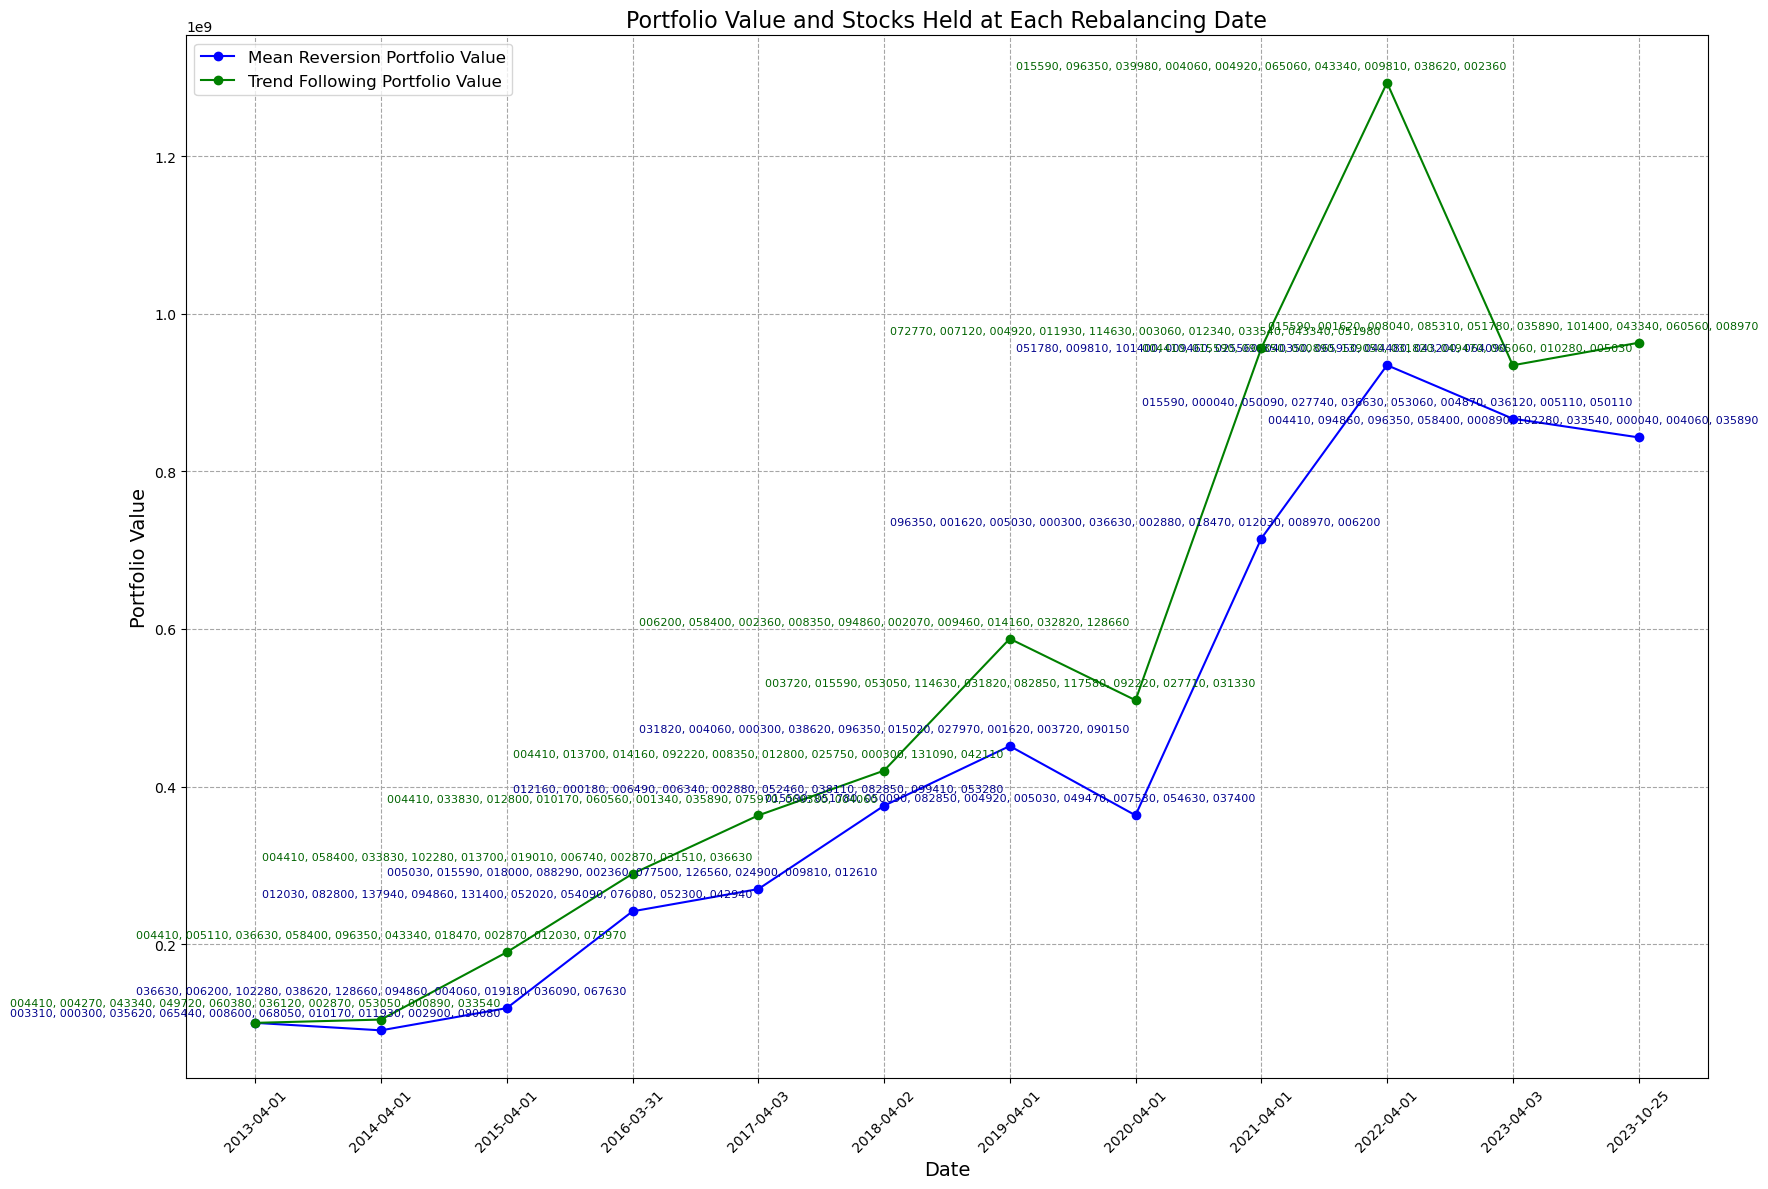

In [11]:
# 시각화
plt.figure(figsize=(18, 12))

# 평균 회귀 전략 결과 시각화
plt.plot(rebalancing_dates + [max_date], mr_portfolio_values, marker='o', linestyle='-', color='b', label='Mean Reversion Portfolio Value')
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(mr_held_stocks[i])
    plt.annotate(stocks_str, (date, mr_portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkblue')

# 추세 추종 전략 결과 시각화
plt.plot(rebalancing_dates + [max_date], tf_portfolio_values, marker='o', linestyle='-', color='g', label='Trend Following Portfolio Value')
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(tf_held_stocks[i])
    plt.annotate(stocks_str, (date, tf_portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkgreen')

plt.title('Portfolio Value and Stocks Held at Each Rebalancing Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", c='0.65')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
